This notebook provides an example of using an exponential Euler solver to train a neural network without falling onto the edge of stability.

In [1]:
from math import sqrt
from statistics import mean

import matplotlib.pyplot as plot
import numpy as np
import torch

import stable_solvers as solvers

Training using an exponential Euler solver is extremely computationally expensive. To keep this tractable, we generate some synthetic data to use.

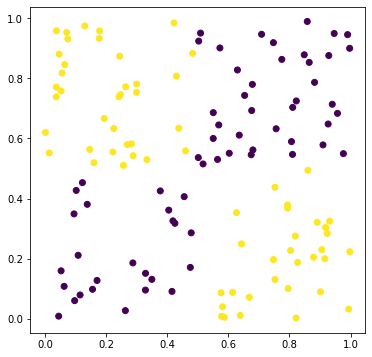

In [2]:
xs = torch.rand((128, 2))
ys = ((xs[:, 0] > 0.5) ^ (xs[:, 1] > 0.5)).long()

plot.figure(figsize=(6, 6))
plot.scatter(xs[:, 0].numpy(), xs[:, 1].numpy(), c=ys.numpy())
plot.show()

In [3]:
torch.manual_seed(1)

net = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ELU(),
    torch.nn.Linear(128, 128),
    torch.nn.ELU(),
    torch.nn.Linear(128, 128),
    torch.nn.ELU(),
    torch.nn.Linear(128, 2),
)

In [4]:
ds = torch.utils.data.TensorDataset(xs.cuda(), ys.cuda())
criterion = torch.nn.CrossEntropyLoss()
loss_func = solvers.LossFunction(dataset=ds, criterion=criterion, batch_size=128, net=net)

We use a simple multi-layer perceptron (MLP) as our network. Note that we use the Exponential Linear Unit (ELU) for the activation function instead of the ReLU, because the exponential Euler solver relies on the assumption that the network is a smooth function.

In [5]:
params = loss_func.initialize_parameters(device='cuda')
solver = solvers.ExponentialEulerSolver(
    params, loss_func, 0.01, 2
)

And now we train the network:

In [6]:
step = solver.step()
losses, dts = [step.loss], [step.dt]

while losses[-1] > 0.1:
    step = solver.step()
    losses.append(step.loss)
    dts.append(step.dt)

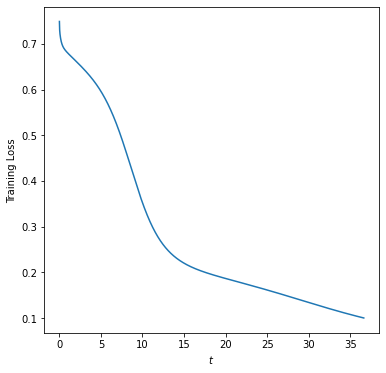

In [7]:
plot.figure(figsize=(6, 6))
plot.plot(
    np.cumsum(dts),
    losses
)
plot.xlabel('$t$')
plot.ylabel('Training Loss')
plot.show()